In [1]:
from argparse import Namespace

import torch
from torch import nn
from tqdm.notebook import tqdm, trange
from torch.utils.data import DataLoader

# Chapter 1: Offline LTR <a class="anchor" id="o_LTR"></a>

A typical setup of learning to rank involves a feature vector constructed using a query-document pair, and a set of relevance judgements. In this assignment, you are given a small dataset that consists of number of queries with their corresponding list of documents. As the first step, you need to extract features for this dataset, and then use them in order to perform learninig-to-rank with different loss functions. In particular, the information about each of the files in this dataset is as follows:

    - `collection.tsv`: Each line consists of _document ID_ and the _document text_
    - `queries.tsv`: Each line consists of _query ID_ and the _query text_
    - `(train/dev/test)_pairs_graded.tsv`: Each line consists of _query ID_, _document ID_, _relevance score_; where relevance grade is an *ordinal* variable  with  5  grades,  for example: {`perfect`,`excellent`,`good`,`fair`,`bad`).


## Section 1: Feature Extraction <a class="anchor" id="dataU"></a>

[Back to TOC](#top)

The following cell contains the path of raw dataset files and a file with the list of stop words. 



In [2]:
# IMPORTANT: DO NOT CHANGE ANY OF THE FILE PATHS.

COLLECTION_PATH = "./data/collection.tsv"
QUERIES_PATH = "./data/queries.tsv"
TRAIN_PATH = "./data/train_pairs_graded.tsv"
DEV_PATH = "./data/dev_pairs_graded.tsv"
TEST_PATH = "./data/test_pairs_graded.tsv"
STOP_WORDS_PATH = "./data/common_words"

First, you need to preprocess query and document texts and extract term based statistics for documents.

In [3]:
from ltr.dataset import Documents, Queries, Preprocess
prp = Preprocess(STOP_WORDS_PATH)

queries = Queries(prp)
queries.preprocess_queries(QUERIES_PATH)

In the next cell, you will use `Documents` class to extract document term-based stats, as this process might take longer, `if` statement and  `RESET` allows you to skip this step after the first time.

ToDo: 

Complete the implementation of `process_documents` function. you can find the implemenation in `ltr.dataset`.

In [4]:
# IMPORTANT: DO NOT CHANGE DOC_JSON PATH
DOC_JSON = "./datasets/doc.pickle"
import os
import pickle
RESET = False
if os.path.exists(DOC_JSON) and not RESET:
    with open(DOC_JSON, "rb") as file:
        documents = pickle.load(file)
else:
    documents = Documents(prp)
    documents.process_documents(COLLECTION_PATH)
    with open(DOC_JSON, "wb") as file:
        pickle.dump(documents, file)

The class `FeatureExtraction` in `ltr.dataset` is defined for extracting features. This class includes a class `extract` method, that will extract predefined features for each query-document pair. The other class, `GenerateFeatures` is already implemented to allow for reading lines of `(train\dev\test)_pairs_graded.tsv` files one by one, extract the features, and write them in the `(train\dev\test)_pairs_graded.tsv`. The `FeatureExtraction` class has the following property: `features` that is a `dict` with feature names as the keys and their values as dictionary values. The list of features that you have to implement can be found in `__feature_list__` inside `ltr.dataset` and also listed in `README.md` file.

In [5]:
# IMPORTANT: DO NOT CHANGE `args` VALUES FOR BM25 CALCULATION
N_FEATURES = 15

from ltr.dataset import FeatureExtraction, GenerateFeatures

feature_ex = FeatureExtraction({}, documents, queries)

feat_gen = GenerateFeatures(feature_ex)
args = {}
args["k1"] = 1.5
args["b"] = 0.75
args["idf_smoothing"] = 0.5

ToDo: 

Implement method `extract` in `ltr.dataset.FeatureExtraction`. This method should return a dictionary with feature names as the keys and their values as dictionary values. This method is called inside `run` method of `GenerateFeatures` class. You can pass any required arguments thorugh `args`. For instance, as defiend in previous cell, you can pass `k1` and `b` as BM25 arguments thorugh `args`.

In [6]:
feat_gen.run(TRAIN_PATH, TRAIN_PATH+'g', **args)
feat_gen.run(DEV_PATH, DEV_PATH+'g', **args)
feat_gen.run(TEST_PATH, TEST_PATH+'g', **args)

96985it [00:52, 1863.50it/s]
19500it [00:10, 1868.76it/s]
48127it [00:25, 1908.03it/s]


The `DataSet` class will read the generated feature files for train/valid/test splits and you can use them for training LTR models with different ranking loss functions.

In [6]:
#IMPORTANT: DO NOT CHANGE THE `fold_paths`

from ltr.dataset import DataSet

fold_paths = ["./data/"]
num_relevance_labels = 5
num_nonzero_feat = N_FEATURES
num_unique_feat = N_FEATURES
data = DataSet(
        "ir1-2023",
        fold_paths,
        num_relevance_labels,
        num_unique_feat,
        num_nonzero_feat)

data = data.get_data_folds()[0]
data.read_data()

In [7]:
print(f"Number of features: {data.num_features}")
# print some statistics
for split in ["train", "validation", "test"]:
    print(f"Split: {split}")
    split = getattr(data, split)
    print(f"\tNumber of queries {split.num_queries()}")
    print(f"\tNumber of docs {split.num_docs()}")

Number of features: 15
Split: train
	Number of queries 961
	Number of docs 89506
Split: validation
	Number of queries 195
	Number of docs 19500
Split: test
	Number of queries 483
	Number of docs 48127


### Section 1.2 Utility classes/methods

You can use `LTRData` class in this assignment that is defined in `ltr.dataset`. 

In [8]:
from ltr.dataset import LTRData
## example 
train_dl = DataLoader(LTRData(data, "train"), batch_size=32, shuffle=True)
# this is how you would use it to quickly iterate over the train/val/test sets 
# - (of course, without the break statement!)
for (x, y) in train_dl:
    print(x.size(), y.size())
    break

torch.Size([32, 15]) torch.Size([32])


You can use `evaluate_model` from `ltr.eval` to evaluate a model, on a given split.

In [9]:
from ltr.eval import evaluate_model
## example 
# function that scores a given feature vector e.g a network
net = nn.Linear(N_FEATURES, 1)
# the evaluate method accepts a function. more specifically, a callable (such as pytorch modules) 
def notwork(x):
    return net(x)
# evaluate the function
_ = evaluate_model(data, notwork, split="validation", print_results=True)

"metric": "mean" ("standard deviation")
dcg: 8.0293 (9.40233)
dcg@03: 2.0942 (5.05413)
dcg@05: 2.4193 (5.11129)
dcg@10: 3.0754 (5.51470)
dcg@20: 4.1283 (6.23935)
ndcg: 0.3250 (0.19242)
ndcg@03: 0.1060 (0.24438)
ndcg@05: 0.1195 (0.24163)
ndcg@10: 0.1436 (0.24663)
ndcg@20: 0.1830 (0.24588)
precision@01: 0.0879 (0.28317)
precision@03: 0.0678 (0.15913)
precision@05: 0.0527 (0.10200)
precision@10: 0.0440 (0.07142)
precision@20: 0.0376 (0.05764)
recall@01: 0.0499 (0.19200)
recall@03: 0.1214 (0.29985)
recall@05: 0.1599 (0.33349)
recall@10: 0.2278 (0.37686)
recall@20: 0.3568 (0.43218)
relevant rank: 47.8980 (33.14513)
relevant rank per query: 116.0604 (179.63315)


The next cell is used to generate reproducible results:

In [10]:
# use to get reproducible results
from ltr.utils import seed
from ltr.utils import create_results


## Section 2: Pointwise LTR <a class="anchor" id="pointwiseLTR"></a>

[Back to TOC](#top)

Let $x \in \mathbb{R}^d$ be an input feature vector, containing features for a query-document pair. Let $f: \mathbb{R}^d \rightarrow \mathbb{R} $ be a function that maps this feature vector to a number $f(x)$ - either a relevance score (regression) or label (classification). The data $\{x \}$ are treated as feature vectors and the relevance judgements are treated as the target which we want to predict. 

In this section, you will implement a simple Pointwise model using either a regression loss, and use the train set to train this model to predict the relevance score. 


### Section 2.1: Neural Model


\# ToDO:
Implement the following methods for the Class `LTRModel` in `ltr.model`:
  - `__init__`
  - `forward`

We will use this neural network to learn a LTR model with different loss functions(Pointwise, Pairwise, Listwise), using the relevance grades as the label. This network should have the following attribute:
  - `layers`: $N _FEATURES (input) \rightarrow 10 \rightarrow 1$ where each layer is a linear layer (`nn.Linear`) with a ReLu activation function (`nn.ReLU`) in between the layers. Use the default weight initialization scheme. (Hint: use `nn.Sequential` for a one-line forward function!)

In [11]:
from ltr.model import LTRModel
 
# check the network configuration - layer dimensions and configurations
point_nn_reg = LTRModel(data.num_features)
print(point_nn_reg)


LTRModel(
  (layers): Sequential(
    (layer1): Linear(in_features=15, out_features=10, bias=True)
    (relu1): ReLU()
    (out): Linear(in_features=10, out_features=1, bias=True)
  )
)


\#ToDo:
Implement regression loss in `pointwise_loss` function. You can find the definition in `ltr.ltr`.

In [12]:
from ltr.loss import pointwise_loss


\# ToDO:
Implement `train_pointwise` function in `ltr.ltr` as a wrapper for training a pointwise LTR, that takes the model as input and trains the model.

In [13]:
from ltr.train import train_pointwise

In [14]:
# Change this to test your code!
pointwise_test_params = Namespace(epochs=1, 
                    lr=1e-3,
                    batch_size=256,
                   metrics={"ndcg"})
# uncomment to test your code
## train a regression model
met_reg = train_pointwise(point_nn_reg, pointwise_test_params, data)


The function `create_results` is defined in `ltr.utils` to create the results. It could be used  to generate your results:

In [15]:
# IMPORTANT DO NOT CHANGE seed, params, or any of the PATH variables
from ltr.utils import create_results

seed(42)

params_regr = Namespace(epochs=11, 
                    lr=1e-3,
                    batch_size=1,
                    metrics={"ndcg", "precision@05", "recall@05"})

pointwise_regression_model = LTRModel(data.num_features)
pw_regr = create_results(data, pointwise_regression_model, 
                          train_pointwise, 
                          pointwise_regression_model,
                          "./outputs/pointwise_res.json",
                          params_regr)

torch.save(pointwise_regression_model.state_dict(), "./outputs/pointwise_model")

Training Model


/Users/tuanddoox/Documents/UvA/study/IR1_23/Assignment/assignment2-part1-team-54/ltr/loss.py:21: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  MSE = F.mse_loss(output.squeeze(), target)
                                                         

"metric": "mean" ("standard deviation")
dcg: 17.0439 (13.54747)
dcg@03: 12.6066 (8.60225)
dcg@05: 13.6921 (9.27857)
dcg@10: 14.7906 (10.30265)
dcg@20: 15.7053 (11.55088)
ndcg: 0.7769 (0.25373)
ndcg@03: 0.6756 (0.37581)
ndcg@05: 0.6962 (0.34239)
ndcg@10: 0.7212 (0.31245)
ndcg@20: 0.7416 (0.29110)
precision@01: 0.6771 (0.46760)
precision@03: 0.3719 (0.25559)
precision@05: 0.2655 (0.19683)
precision@10: 0.1586 (0.13911)
precision@20: 0.0925 (0.09518)
recall@01: 0.4906 (0.43534)
recall@03: 0.6761 (0.40224)
recall@05: 0.7522 (0.36381)
recall@10: 0.8244 (0.31660)
recall@20: 0.8895 (0.26071)
relevant rank: 13.8291 (20.97073)
relevant rank per query: 32.4321 (90.49092)


## Section 3: Pairwise LTR <a class="anchor" id="pairwiseLTR"></a>

[Back to TOC](#top)

In this section,  you will learn and implement RankNet, a  pairwise learning to rank algorithm.

For a given query, consider two documents $D_i$ and $D_j$ with two different ground truth relevance  labels,  with  feature  vectors $x_i$ and $x_j$ respectively.   The  RankNet  model,  just  like  the pointwise model, uses $f$ to predict scores i.e $s_i=f(x_i)$ and $s_j=f(x_j)$, but uses a different loss during  training. $D_i \triangleright D_j$ denotes  the  event  that $D_i$ should  be  ranked  higher  than $D_j$.   The  two outputs $s_i$ and $s_j$ are mapped to a learned probability that $D_i \triangleright D_j$: 


$$        P_{ij} = \frac{1}{1 + e^{-\sigma(s_i - s_j)}} $$
  
where $\sigma$ is a parameter that determines the shape of the sigmoid. The loss of the RankNet model is the cross entropy cost function:

$$        C = - \bar{P}_{ij} \log P_{ij} - (1-\bar{P}_{ij}) \log (1 - P_{ij}) $$

As the name suggests, in the pairwise approach to LTR, we optimize a loss $l$ over pairs of documents. Let $S_{ij} \in \{0, \pm1 \}$ be equal to $1$ if the relevance of document $i$ is greater than document $j$; $-1$ if document $j$ is more relevant than document $i$; and 0 if they have the same relevance. This gives us $\bar{P}_{ij} = \frac{1}{2} (1 + S_{ij})$ so that $\bar{P}_{ij} = 1$ if $D_i \triangleright D_j$; $\bar{P}_{ij} = 0$ if $D_j \triangleright D_i$; and finally $\bar{P}_{ij} = \frac{1}{2}$ if the relevance is identical. This gives us:

$$        C = \frac{1}{2}(1- S_{ij})\sigma(s_i - s_j) + \log(1+ e^{-\sigma(s_i - s_j)}) $$

Now, consider a single query for which $n$ documents have been returned. Let the output scores of the ranker be $s_j$ ; $j=\{1, \dots, n \}$, the model parameters be $w_k \in \mathbb{R}^W$, and let the set of pairs of document indices used for training be $\mathcal{P}$. Then, the total cost is $C_T = \sum_{i,j \in \mathcal{P}} C(s_i; s_j)$. 



- Implement RankNet. You should construct training samples by creating all possible pairs of documents for a given query and optimizing the loss above. Use the following parameters:
  - Layers: $N_{FEATURES} (input) \rightarrow 10 \rightarrow 1$, where each layer is a linear layer (`nn.Linear`) with a ReLu activation function (`nn.ReLu`) in between the layers. Use the default weight initialization scheme. (Hint: use `nn.Sequential` for a one-line forward function!)

For the pairwise loss, we need to have a structured **dataloader** which detects the documents associated with a specific query. The class `QueryGroupedLTRData` is defined in `ltr.dataset` for this end.

In [16]:

from ltr.dataset import QueryGroupedLTRData
    
## example
train_data = QueryGroupedLTRData(data, "train")
# this is how you would use it to quickly iterate over the train/val/test sets 

q_i = 300
features_i, labels_i = train_data[q_i]
print(f"Query {q_i} has {len(features_i)} query-document pairs")
print(f"Shape of features for Query {q_i}: {features_i.size()}")
print(f"Shape of labels for Query {q_i}: {labels_i.size()}")
        

Query 300 has 100 query-document pairs
Shape of features for Query 300: torch.Size([100, 15])
Shape of labels for Query 300: torch.Size([100])


#ToDO:

First, implement the pairwise loss in `pairwise_loss` function in `ltr.loss` as described above.
Then, implement `train_pairwise` method in `ltr.train`.

In [17]:
from ltr.loss import pairwise_loss
from ltr.train import train_pairwise

Normal training with pairwise loss requires a lot of time, you can investigate normal training of LTRModel with pairwise loss by uncommenting the following cell.

In [19]:
# seed(42)

# params = Namespace(epochs=1, lr=1e-4, batch_size=1, metrics={"ndcg", "precision@05", "recall@05"})
# ## uncomment to test your code
# pairwise_net = LTRModel(N_FEATURES)

# create_results(data, pairwise_net, 
#                train_pairwise, 
#                pairwise_net,
#                "pairwise_normal_res.json",
#                params)

Training Model


"metric": "mean" ("standard deviation")
dcg: 13.7033 (12.59019)
dcg@03: 8.4190 (8.18582)
dcg@05: 9.3259 (8.54862)
dcg@10: 10.5400 (9.13246)
dcg@20: 11.6700 (10.34356)
ndcg: 0.6086 (0.28571)
ndcg@03: 0.4500 (0.40367)
ndcg@05: 0.4735 (0.38527)
ndcg@10: 0.5127 (0.35766)
ndcg@20: 0.5474 (0.33410)
precision@01: 0.4209 (0.49371)
precision@03: 0.2569 (0.23928)
precision@05: 0.1853 (0.16687)
precision@10: 0.1212 (0.11016)
precision@20: 0.0781 (0.08424)
recall@01: 0.2952 (0.40951)
recall@03: 0.4785 (0.44498)
recall@05: 0.5485 (0.43967)
recall@10: 0.6645 (0.40791)
recall@20: 0.7776 (0.35480)
relevant rank: 21.0047 (25.34624)
relevant rank per query: 49.2606 (107.50955)


{'metrics': {'metrics_val': [{'dcg': (13.69904444164106, 11.862904482197845),
    'dcg@03': (8.343161479011068, 7.967358340455433),
    'dcg@05': (9.181095246498328, 8.057938905973426),
    'dcg@10': (10.368186972498421, 8.62235860823887),
    'dcg@20': (11.396375847518362, 9.262986680515064),
    'ndcg': (0.6070974409392565, 0.28460061602028275),
    'ndcg@03': (0.44542020292023626, 0.3994130843513768),
    'ndcg@05': (0.46743312717883445, 0.3798891882677308),
    'ndcg@10': (0.5066262922593361, 0.35990756246019145),
    'ndcg@20': (0.5433859465215266, 0.333701621888758),
    'precision@01': (0.4340659340659341, 0.495633633795571),
    'precision@03': (0.25641025641025644, 0.23480396352435673),
    'precision@05': (0.1813186813186813, 0.15220871147477247),
    'precision@10': (0.11978021978021977, 0.1045343207952657),
    'precision@20': (0.07582417582417583, 0.07200527963038825),
    'recall@01': (0.29638918773534156, 0.4052751290491361),
    'recall@03': (0.4709127411050488, 0.43977

## Section 4: Pairwise: Speed-up RankNet <a class="anchor" id="SpairwiseLTR"></a>

[Back to TOC](#top)

To speed up training of the previous model, we can consider a sped up version of the model, where instead of `.backward` on the loss, we use `torch.backward(lambda_i)`. 

The derivative of the total cost $C_T$ with respect to the model parameters $w_k$ is:

$$        \frac{\partial C_T}{\partial w_k} = \sum_{(i,j) \in \mathcal{P}} \frac{\partial C(s_i, s_j)}{\partial s_i} \frac{\partial s_i}{\partial w_k} + \frac{\partial C(s_i, s_j)}{\partial s_j} \frac{\partial s_j}{\partial w_k} $$

We can rewrite this sum by considering the set of indices $j$ , for which $\{i,j\}$ is a valid pair, denoted by $\mathcal{P}_i$, and the set of document indices $\mathcal{D}$:

$$
\frac{\partial C_T}{\partial w_k} = \sum_{i \in \mathcal{D}}
\frac{\partial s_i}{\partial w_k} \sum_{j \in \mathcal{P}_i} 
\frac{\partial C(s_i, s_j)}{\partial s_i} 
$$

This sped of version of the algorithm first computes scores $s_i$ for all the documents. Then for each $j= 1, \dots, n$, compute:

$$
\lambda_{ij} = \frac{\partial C(s_i, s_j)}{\partial s_i} = \sigma \bigg( \frac{1}{2}(1 - S_{ij}) -  \frac{1}{1 + e^{\sigma(s_i -s_j))}} \bigg) \\
\lambda_i = \sum_{j \in \mathcal{P}_i} \frac{\partial C(s_i, s_j)}{\partial s_i} = \sum_{j \in \mathcal{P}_i} \lambda_{ij}
$$

That gives us:

$$
\frac{\partial C_T}{\partial w_k} = \sum_{i \in \mathcal{D}}
\frac{\partial s_i}{\partial w_k} \lambda_i
$$

This can be directly optimized in pytorch using: `torch.autograd.backward(scores, lambda_i)` 
 


\# ToDO:

Implement the `compute_lambda_i` for the sped-up version of pairwise loss as described above. You can find the function definiton in `ltr.ltr`.

In [13]:
from ltr.loss import compute_lambda_i

In [14]:
from ltr.loss import mean_lambda

\# ToDO:

Implement `train_pairwise_spedup` function for more efficient training with pairwise loss. You can find the definition in `ltr.train`. 

In [22]:
from ltr.train import train_pairwise_spedup

In [23]:
# IMPORTANT DO NOT CHANGE seed, params, or any of the PATH variables

seed(42)
params = Namespace(epochs=10, 
                    lr=1e-3,
                    batch_size=1,
                    metrics={"ndcg", "precision@05", "recall@05"})
sped_up_pairwise_model = LTRModel(N_FEATURES)


create_results(data, sped_up_pairwise_model, 
               train_pairwise_spedup, 
               sped_up_pairwise_model,
               "./outputs/pairwise_spedup_res.json",
               params)

torch.save(sped_up_pairwise_model.state_dict(), "./outputs/pairwise_spedup_model")

Training Model


"metric": "mean" ("standard deviation")
dcg: 17.5001 (13.63114)
dcg@03: 13.2848 (8.61828)
dcg@05: 14.2319 (9.44167)
dcg@10: 15.3446 (10.60896)
dcg@20: 16.2030 (11.72150)
ndcg: 0.7977 (0.25031)
ndcg@03: 0.7100 (0.36272)
ndcg@05: 0.7208 (0.34078)
ndcg@10: 0.7452 (0.31005)
ndcg@20: 0.7637 (0.29091)
precision@01: 0.7127 (0.45251)
precision@03: 0.3935 (0.25771)
precision@05: 0.2735 (0.19986)
precision@10: 0.1617 (0.14174)
precision@20: 0.0938 (0.09471)
recall@01: 0.5165 (0.43314)
recall@03: 0.7118 (0.38638)
recall@05: 0.7705 (0.35607)
recall@10: 0.8315 (0.31216)
recall@20: 0.8988 (0.24968)
relevant rank: 12.8443 (19.72928)
relevant rank per query: 30.1225 (90.51656)


##  Section 5: Listwise LTR <a class="anchor" id="listwiseLTR"></a>

[Back to TOC](#top)

In this section, you will implement LambdaRank, a listwise approach to LTR. Consider the computation of $\lambda$ for sped-up RankNet (that you've already implemented). $\lambda$ here amounts to the 'force' on a document given its neighbours in the ranked list. The design of $\lambda$ in LambdaRank is similar to RankNet, but is scaled by DCG gain from swapping the two documents in question. Let's suppose that the corresponding ranks of doucment $D_i$ and $D_j$ are $r_i$ and $r_j$ respectively. Given a ranking measure $IRM$, such as $NDCG$ or $ERR$, the lambda function in LambdaRank is defined as:


$$        \frac{\partial C}{\partial s_i} = \sum_{j \in D} \lambda_{ij} \cdot |\bigtriangleup IRM (i,j)| $$

Where $|\bigtriangleup IRM(i,j)|$ is the absolute difference in $IRM$ after swapping the rank positions $r_i$ and $r_j$ while leaving everything else unchanged ($| \cdot |$ denotes the absolute value). Note that we do not backpropogate $|\bigtriangleup IRM|$, it is treated as a constant that scales the gradients. In this assignment we will use $|\bigtriangleup NDCG|$

\# ToDO:

Implement the listwise loss in `listwise_loss` function defined in `ltr.ltr`



In [25]:
from ltr.loss import listwise_loss

The function `mean_lambda_list` is defined in `ltr.ltr`.

\# ToDo:
Implement `train_listwise` function to train with list_wise loss. you can find the definition in `ltr.train`.

In [26]:
from ltr.loss import mean_lambda_list
from ltr.train import train_listwise

In [27]:
# IMPORTANT DO NOT CHANGE seed, params, or any of the PATH variables

seed(42)
params = Namespace(epochs=11, 
                    lr=1e-4,
                    batch_size=1,
                    metrics={"ndcg", "precision@05", "recall@05"})
listwise_model = LTRModel(N_FEATURES)

create_results(data, listwise_model, 
               train_listwise, 
               listwise_model,
               "./outputs/listwise_res.json",
               params)

torch.save(listwise_model.state_dict(), "./outputs/listwise_model")


Training Model


"metric": "mean" ("standard deviation")
dcg: 17.5417 (13.60404)
dcg@03: 13.2412 (8.59308)
dcg@05: 14.2785 (9.33687)
dcg@10: 15.3601 (10.52052)
dcg@20: 16.2880 (11.73983)
ndcg: 0.8016 (0.25032)
ndcg@03: 0.7120 (0.36549)
ndcg@05: 0.7260 (0.33955)
ndcg@10: 0.7484 (0.31144)
ndcg@20: 0.7687 (0.28876)
precision@01: 0.7216 (0.44821)
precision@03: 0.3883 (0.25743)
precision@05: 0.2717 (0.19601)
precision@10: 0.1617 (0.14190)
precision@20: 0.0945 (0.09779)
recall@01: 0.5270 (0.43318)
recall@03: 0.7073 (0.39356)
recall@05: 0.7679 (0.35721)
recall@10: 0.8340 (0.30924)
recall@20: 0.9021 (0.24422)
relevant rank: 12.6534 (19.34651)
relevant rank per query: 29.6748 (87.78832)


## Section 6: Comparing Pointwise, Pairwise and Listwise<a class="anchor" id="evaluation1"></a>

[Back to TOC](#top)

In the next few cells, we will compare the methods you've implemented. Helper functions are provided for you, which you can use to make some conclusions. You can modify the code as needed!

First, let's have a function that plots the average scores of relevant (levels 3 and 4) and non-relevant (levels 0, 1, and 2) scores in terms of training epochs for different loss functions:

In [28]:
# Load metrics and models
import json

pointwise_temp_model = LTRModel(N_FEATURES)
pointwise_temp_model.load_state_dict(torch.load("./outputs/pointwise_model"))

pairwise_temp_model = LTRModel(N_FEATURES)
pairwise_temp_model.load_state_dict(torch.load("./outputs/pairwise_spedup_model"))

listwise_temp_model = LTRModel(N_FEATURES)
listwise_temp_model.load_state_dict(torch.load("./outputs/listwise_model"))


methods = [
    {"results_file": "./outputs/pointwise_res.json", "label": "Pointwise"},
    {"results_file": "./outputs/pairwise_spedup_res.json", "label": "Pairwise"},
    {"results_file": "./outputs/listwise_res.json", "label": "Listwise"}
]

labels = []
results = []
q_results = []
for m in methods:
    labels.append(m["label"])
    
    with open(m["results_file"]) as reader:
        r = json.load(reader)
    
    results.append(r["test_metrics"])
    q_results.append(r["test_query_level_metrics"])

In the following cell, `compare_methods` and `plot_distribution` figures are imported. You can use the them for your analysis and observe how the different loss functions compare to each other.

In [29]:
from ltr.utils import compare_methods
from ltr.utils import plot_distribution

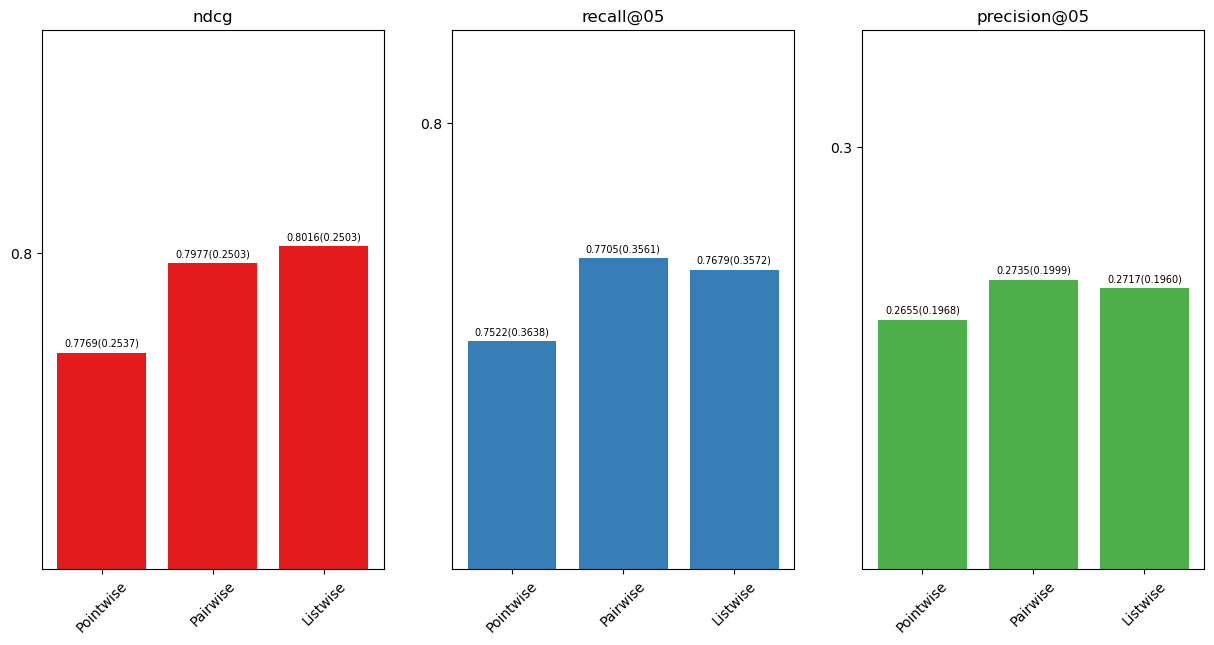

In [30]:
compare_methods(labels, results)

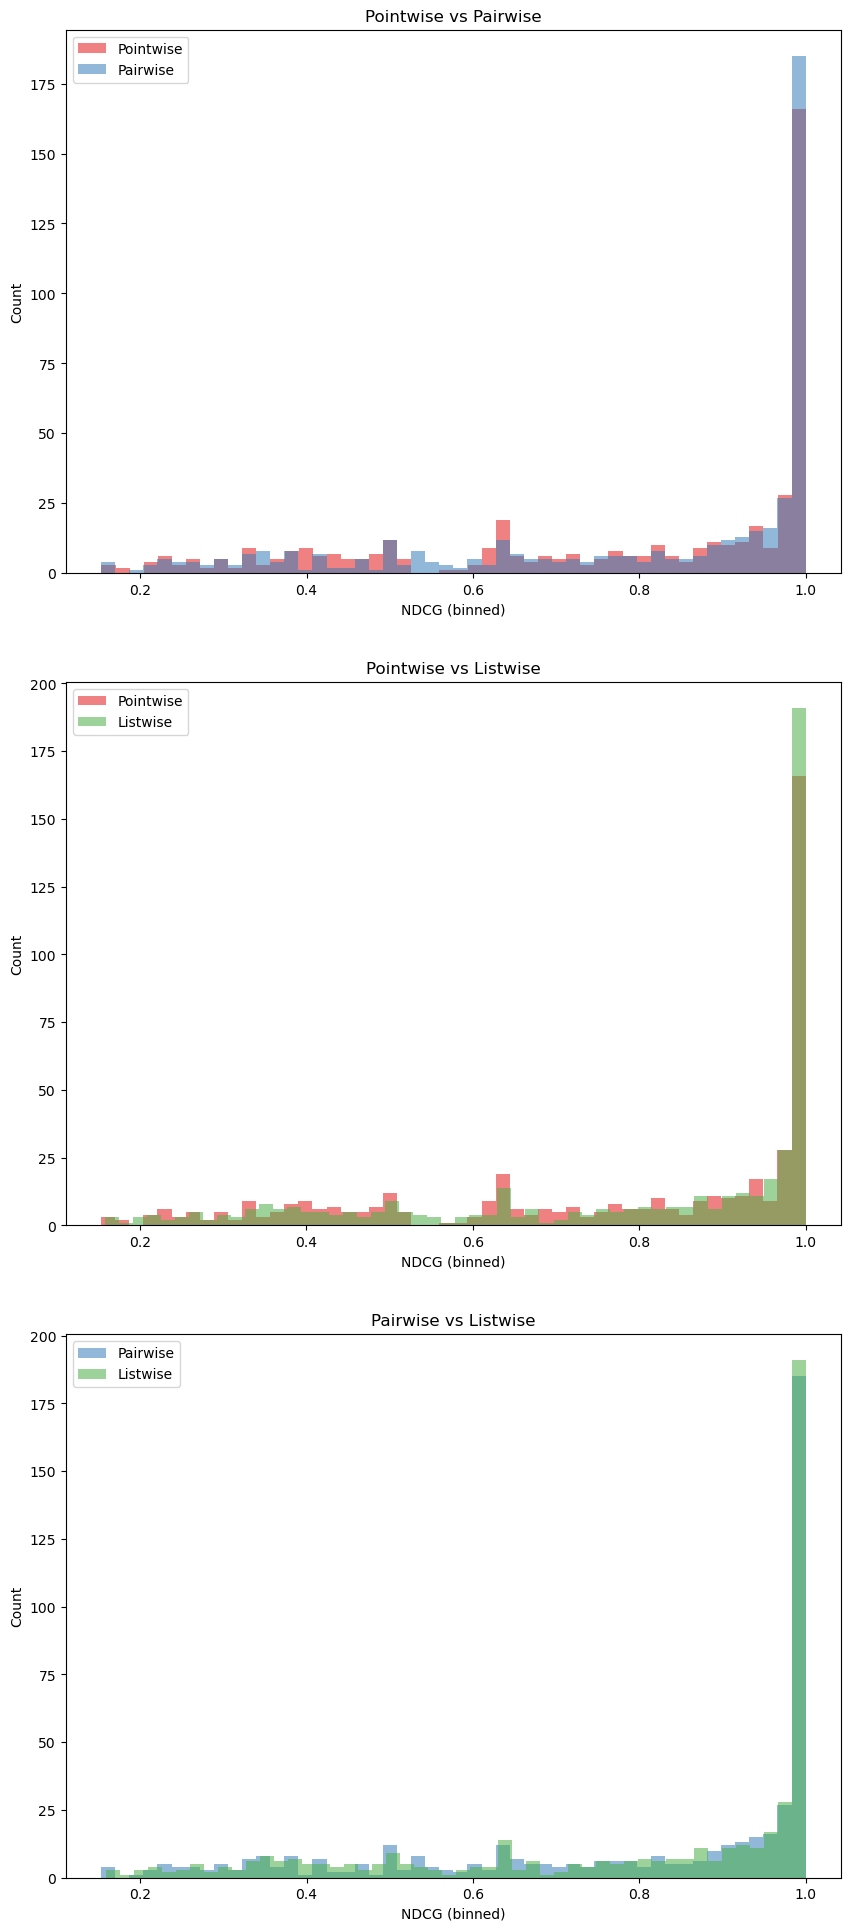

In [31]:
plot_distribution(labels, q_results)

1- Given the training results and evaluation results, please elaborate on the ranking performance with different loss functions.

2- In this assignment, you extracted N_FEATURES features for each query-document pair. Now, consider adding 1-2 new features, and run the training again. Analyze training performance with the extended feature vectors.

See `analysis.md` for further details and to submit your results.